# Step4 演習03 ロジスティック回帰からニューラルネットへ
---

Step4では手書き数字の認識(Optical Character Recognition; OCR)を実装します。

まずはロジスティック回帰で実装を行い、モデルやパラメータを変更することによってスコアへどのような影響があるか体験してもらいます。

今回はscikit-learnを利用して実装を行います。

OCRはマルチクラス分類問題ですが、scikit-learnの`LogisticRegression()`を使うとオプションなしで一対多分類器として動いてくれるため、とても簡単にOCRを実装できます。

次に、ニューラルネットワークでロジスティック回帰を実装します。

多層のニューラルネットワークへの学習（ディープラーニング）もパラメータを変えるだけで実現できるので、学習にかかる時間とスコアの違いを身をもって体感してください。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での使用は避けてください。

**本演習の目的**
- 正則化を使うことで訓練データ以外のデータに対してもスコアが改善されるかを確かめる。
- L2正則化とＬ1正則化の違いを学ぶ。

## ライブラリのインポート

まずはじめに、利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [scikit-learn](http://scikit-learn.org/stable/index.html) Pythonのオープンソース機械学習ライブラリの公式ドキュメント

ドキュメントには有用な情報が書き記されています。何か迷ったときには必ずドキュメントに戻ってくるようにしましょう。

次のセルをそのまま実行（"SHIFT" + "ENTER"）してください。コードが書いてあるセルは**上から順番に**順次実行してください。

** 注意： **初めてmatplotlibを使うユーザーは、フォント一覧のキャッシュが存在しないため、このセルの実行でWarningが出ます。もう一度実行すると、すでにキャッシュができているので、Warningなく走ります。

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
font = {'family':'IPAexGothic'}
plt.rc('font', **font)

## 今回使うデータに関して
数字OCRのサンプルデータとしてMNISTが有名です。MNISTは手書き数字の画像のデータセットになっています。機械学習業界の"Hello, world!"ということができるでしょう。これからMNISTとはいったいどういったものなのか使用するデータの性質をみていきましょう。

「0」から「9」までの10種類の数字をこれから判別します。

In [2]:
num_labels = 10 #「0」から「9」の数字をこれから判別します。

## MNISTデータのロード
データをロードします。
mldata.orgからMNIST originalデータをダウンロードします。使用している回線によっては時間がかかる場合があります。

一度ダウンロードしたらキャッシュしますので、再度走らせるときはダウンロードの時間がかかりません。

In [3]:
mnist = datasets.fetch_mldata('MNIST original')

今回使用するMNISTの画像の枚数は70000枚、画像データのと特徴は28x28 = 784ピクセルです。

- 画像データの数：70000枚
- 画像データの特徴：28x28 = 784ピクセル

下のセルを実行することで画像データの数を** num_data **に、画像データの特徴を** input_layer_size  ** にそれぞれ格納します。


In [4]:
num_data, input_layer_size = mnist.data.shape #70000枚の28x28=784ピクセルの画像です

In [5]:
print("訓練データ数：{}".format(num_data))
print("訓練データの特徴の数：{}".format(input_layer_size))

訓練データ数：70000
訓練データの特徴の数：784


## データのシャッフル
MNIST originalデータをシャッフルしてその冒頭3000サンプルだけ訓練データとして利用することにします。

今回使用するMNISTデータのサンプル数は70000です。この全てを訓練データとして使ってしまうと、学習に使用しなかったデータに対しても正しく予測してくれるのか判断する方法がなくなってしまいます。試作段階では全てのデータを学習に用いてはいけません。（詳しくはStep5で学びます）

また今回10分の1未満のデータせセットしか学習に使わないのは別の理由もあります。マシンスペックの関係で、膨大なデータを用いると学習がなかなか終わらないためです。今回は3000サンプルのみを使用します。

ここで3000サンプルをピックアップする前にデータをシャッフルするのは何故でしょうか。例えば、データがラベル(y)に対してソートされていたとします。すると、そのまま冒頭3000サンプルを取ってしまうと、0, 1と書いてあるデータばかりが集まってしまうことになってしまいます。ぱっと見で分からないような規則でソートされている可能性もあるので、一見バラバラに見えても必ず最初にシャッフルしましょう。

下のセルを実行すると3000サンプルをランダムにシャッフルしたデータを、** X ** と ** y ** にそれぞれ格納してくれます。

In [6]:
shuffle_idx = np.random.permutation(num_data)
X = mnist.data[shuffle_idx[:3000]]   # ランダム化された画像データ3000枚
y = mnist.target[shuffle_idx[:3000]] # 各画像（3000枚）に書かれている数字（「正しい答え」）

データのシャッフルはscikit-learnのtrain_test_splitを使うこともできます。これは訓練用のデータとテスト用のデータを分けてくれるので便利です。習熟したらscikit-learnチュートリアルを読んでこれを使いましょう。

参考：
[scikit-learnチュートリアル sklearn.cross_validation.train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html#sklearn.cross_validation.train_test_split)

訓練例の数(3000個)は`m`、特徴の数(784ピクセル)は`n`に格納します。

In [7]:
m, n = X.shape #訓練例の数はm, 特徴の数はn

In [8]:
print("訓練例の数：{}".format(m))
print("特徴の数：{}".format(n))

訓練例の数：3000
特徴の数：784


## データの視覚化
使用するデータの準備ができました。ここではランダムに並べた最初の画像を表示させてみます。

配列`X`には3000枚の画像データ(pixel)が、一列に並んで入っています。（`X`の`shape`は`(3000, 784)`）

この画像を表示させるには、一列に並んでしまっている`3000`枚の画像データをそれぞれ２次元`(28, 28)`に戻す必要があります。それには`reshape`を使います。

下の画像は一枚の数字データに対してreshapeを行なったイメージ図です。

<div align="center"  style="width:70%">
<img src="./dataStep4/img_reshape.png"></div>

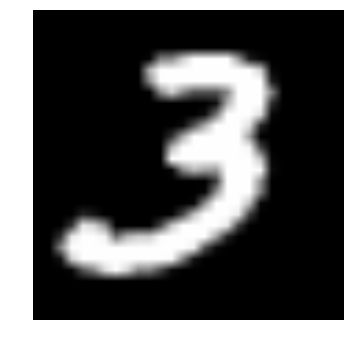

数字 3


In [9]:
X_reshaped = X.reshape((3000, 28, 28))

plt.imshow(X_reshaped[0,:,:])
plt.axis("off")
plt.gray()
plt.show()

print("数字 {0:1.0f}".format(y[0]))

一つだけでは見栄えがしないので、100個表示させるプログラムを関数（ `displayData(images)` ）として実装しておきましょう。

In [10]:
def displayData(images):
    images_reshaped = images.reshape((100, 28, 28))
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow(images_reshaped[i,:,:])
        plt.axis("off")
        plt.gray()
    plt.show()

これを使って、訓練データから冒頭100個選んで視覚化しましょう。多少表示に時間がかかります。

セルの左、In [何某]のところが＊になっているとき、そのセルは実行中です。

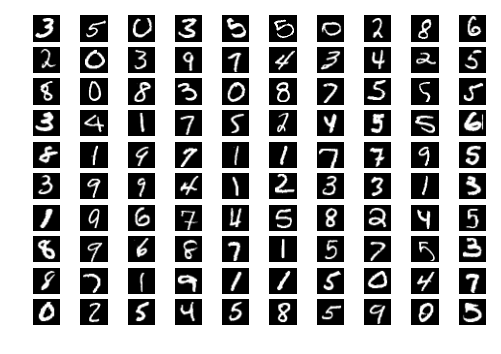

In [11]:
displayData(X[:100, :])

---
## 正則化パラメータを変えるとスコアはどのくらい変わるのか
正則化パラメータ$\lambda$はscikit-learnではその逆数の$C$で表します。つまり、$C$が小さいほど正則化が強く効き、大きいほど正則化の影響は少なくなります。$C$に対するスコアをプロットしてみましょう。

### データセットの準備

In [12]:
X1_train = mnist.data[shuffle_idx[:1000]] #学習時間削減のため1000個だけ対象にする
y1_train = mnist.target[shuffle_idx[0:1000]]
X1_CV = mnist.data[shuffle_idx[1000:1500]]
y1_CV = mnist.target[shuffle_idx[1000:1500]]

In [13]:
fit_iter = 50 #勾配法の繰返し回数

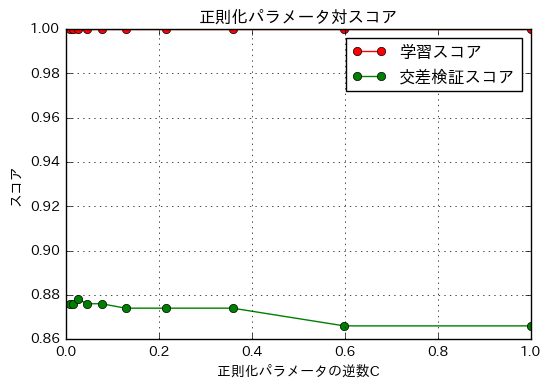

In [14]:
C_num = 10 #10種類のCの値を試します。

score_train = np.empty(C_num)
score_CV = np.empty(C_num)
C = np.logspace(-2,0,C_num) #10の-2乗（つまり0.01）から10の0乗（つまり1）までC_num個対数スケールで選ぶ
for i in range(C_num):
    estimator = LogisticRegression(penalty='l2', C=C[i], max_iter=fit_iter)
    estimator.fit(X1_train,y1_train)
    score_train[i] = estimator.score(X1_train,y1_train)
    score_CV[i] = estimator.score(X1_CV,y1_CV)
plt.figure()
plt.title(u"正則化パラメータ対スコア")
plt.xlabel(u"正則化パラメータの逆数C")
plt.ylabel(u"スコア")
# plt.xscale("log") #x軸を対数スケールにしたいときは、先頭の#（コメントの記号）を外してください。
plt.grid()
plt.plot(C, score_train, 'o-', color="r", label="学習スコア")
plt.plot(C, score_CV, 'o-', color="g", label="交差検証スコア")
plt.legend(loc="best")
plt.show()

正則化以外の問題が大きいせいで、あまり変化が見られません。

---
## 異なる正則化を行ってみる(L1正則化)
異なる正則化を行ってみましょう。何が変わるのでしょうか。

**【課題３】** L1正則化を行ったロジスティック回帰を用いたときのスコアを求めてください。訓練例の個数は1000個にします。

** ヒント：　**<br>
- `LogisticRegression()`に渡すオプションにpenalty="l1"を追加してください。C=10、max_iter=fit_iterとします。
- 学習(fit)で使うデータセットは、「訓練例：X1_train、正解ラベル：X1_train」とします。
- ** score_L1_train **と** score_L1_CV **には** データセットの準備 **で用意したデータセットを渡し、訓練例と交差検証データのスコアの違いを確かめます。

参考：[Scikit-learnチュートリアル sklearn.linear_model.LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [16]:
#Coursemale-02 Step4 QuestionNumber3 1660dceabd1ed7d2a6706fcc0e47b9af
###############ここを穴埋めしてください###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
estimator_L1 = LogisticRegression(penalty="l1", C=10, max_iter=fit_iter)
estimator_L1.fit(X1_train, y1_train)
score_L1_train = estimator_L1.score(X1_train, y1_train)
score_L1_CV = estimator_L1.score(X1_CV, y1_CV)
######################################################
print("学習スコアは",score_L1_train*100,"%、交差検証スコアは",score_L1_CV*100,"%")

学習スコアは 100.0 %、交差検証スコアは 85.6 %


左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [17]:
%%bash
./validation_client.py male-02 4 3 Step4_03.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



---
## L1正則化すると何が変わるのだろう
交差検証スコアを改善するためL２正則化やL1正則化を試しましたが、スコアの改善はみられませんでした。しかしスコアでは見えない部分で大きな変化があったのです。そこで、L1とL2の結果の違いを端的に示すグラフをプロットしてみましょう。フィッティングした後のパラメータの値の分布をグラフにしてみます。
まず** L2正則化 ** したときの分布をプロットしてみます。

学習スコアは 1.0 、交差検証スコアは 0.866


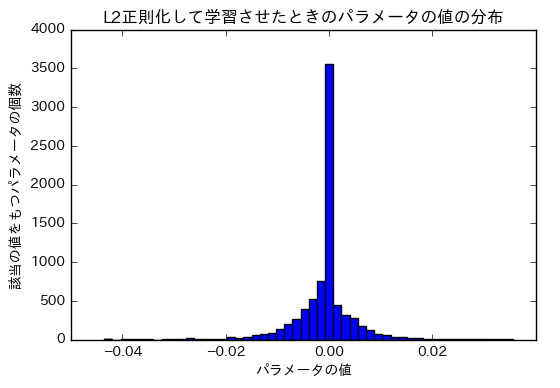

In [18]:
estimator_L2 = LogisticRegression(penalty='l2', C=1, max_iter=fit_iter)
estimator_L2.fit(X1_train,y1_train)
score_L2_train = estimator_L2.score(X1_train,y1_train)
score_L2_CV = estimator_L2.score(X1_CV,y1_CV)
print("学習スコアは",score_L2_train,"、交差検証スコアは",score_L2_CV)
plt.title("L2正則化して学習させたときのパラメータの値の分布")
plt.xlabel("パラメータの値")
plt.ylabel("該当の値をもつパラメータの個数")
_ = plt.hist(estimator_L2.coef_.ravel(), bins=50) #アンダーバー_は普通の変数なのですが、利用しない値を投げ入れるのに慣習的に利用します。

**【課題４】** L1正則化して学習させたときのパラメータの値の分布をプロットしましょう。

学習スコアは 1.0 、交差検証スコアは 0.848


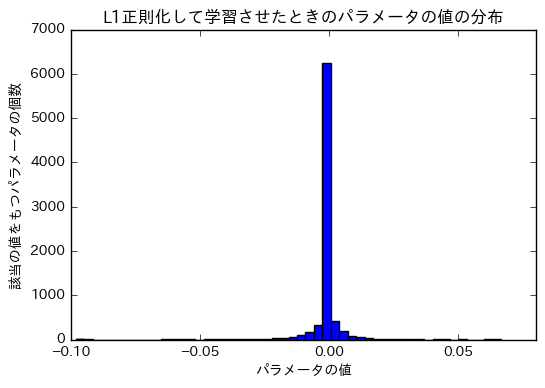

In [19]:
#Coursemale-02 Step4 QuestionNumber4 89b05fe8e0e32fe8702abe74d7c66b0d
###############ここを穴埋めしてください###############
#適切な 関数・変数・値 などにNoneを書き換えてください。
estimator_L1 = LogisticRegression(penalty='l1', C=1, max_iter=fit_iter)
estimator_L1.fit(X1_train,y1_train)
score_L1_train = estimator_L1.score(X1_train,y1_train)
score_L1_CV = estimator_L1.score(X1_CV,y1_CV)
print("学習スコアは",score_L1_train,"、交差検証スコアは",score_L1_CV)
plt.title("L1正則化して学習させたときのパラメータの値の分布")
plt.xlabel("パラメータの値")
plt.ylabel("該当の値をもつパラメータの個数")
_ = plt.hist(estimator_L1.coef_.ravel(), bins=50)
######################################################

左上の**保存マークをクリックした後**、次のセルをShift+Enterで実行して採点します。

In [20]:
%%bash
./validation_client.py male-02 4 4 Step4_03.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



ほとんどのパラメータが0になっていることにお気付きになったでしょうか。

L1正則化をすると、一般に多くのパラメータがゼロになります。このようにほとんどゼロであるというデータの性質を**スパース性**といいます。

スパースだと何が良いのでしょうか？
1. スパースなデータは、ほとんどの要素がゼロであるから、「どこに何の数字がある」という情報だけ記録しておけば、大幅に使用メモリ削減になる。
1. ゼロのところは計算しなくてよいのだから、大幅な高速化に貢献する。
1. どこに何があるという情報は、訓練データの構造を理解するのにも有用である。

このように、重要な性質をいくつも持っているため、スパース性は機械学習において追究すべきトピックの一つとなっています。

L1正則化以外に、スパースなパラメータ（ウェイト）を持つように学習してくれるモデルとして、**サポートベクトルマシン**(SVM)があります。